In [15]:
#setup
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import pandas as pd

allSlots = []
allTabs = []

# # UNCOMMENT FOR TRAINING
# df = pd.read_excel('training_image_names.xlsx', header=None)

# UNCOMMENT FOR TESTING
df = pd.read_excel('test_image_names.xlsx', header=None)

# Flatten all cells and convert to strings, excluding NaN values
image_names = [str(cell) for cell in df.values.flatten() if pd.notna(cell)]

def load_images (image_names):
    all_images = []
    for i in range (len(image_names)):
        image_import = cv2.imread('test images 5pc/'+image_names[i]+'.png', cv2.IMREAD_GRAYSCALE)
        if image_import is None:
            print("Error loading image ",image_names[i] )
            exit()
        else:
            # # Resize the image - input images are 1355 pixels wide
            scale_percent = 45
            width = int(image_import.shape[1] * scale_percent / 100)
            height = int(image_import.shape[0] * scale_percent / 100)
            image = cv2.resize(image_import, (width,height), interpolation = cv2.INTER_AREA)
        all_images.append(image)
    return all_images
all_images = load_images(image_names)


In [ ]:
# get full contour

def extract_complete_piece_contour(rotated_piece):
    # Convert to grayscale if needed
    if len(rotated_piece.shape) == 3:
        gray = cv2.cvtColor(rotated_piece, cv2.COLOR_BGR2GRAY)
    else:
        gray = rotated_piece.copy()
    h, w = gray.shape
        
    # Threshold to get white regions (puzzle pieces are white/light)
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    
    # Find all contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        
    if len(contours) == 0:
        return np.zeros_like(gray), None, binary
    
    # Filter: keep only contours that DON'T touch the image border
    border_margin = 2
    complete_contours = []
    
    for idx, contour in enumerate(contours):
        touches_border = False
        area = cv2.contourArea(contour)
        
        # Check if any point in the contour touches the border
        for point in contour:
            x, y = point[0]
            if (x <= border_margin or x >= w - border_margin or 
                y <= border_margin or y >= h - border_margin):
                touches_border = True
                break
        
        # Keep only contours that don't touch border
        if not touches_border:
            complete_contours.append(contour)
    
    # Create empty image for the contour
    contour_image = np.zeros_like(gray)
    
    if len(complete_contours) > 0:
        # Get the largest complete contour (the full puzzle piece)
        largest_contour = max(complete_contours, key=cv2.contourArea)
        
        
        # Draw only the contour boundary
        cv2.drawContours(contour_image, [largest_contour], -1, 255, 1)
        
        contour_points = largest_contour
    else:
        print("no complete contours found (all pieces touch borders)")
        # Show which borders are touched by the largest contour
        if len(contours) > 0:
            largest = max(contours, key=cv2.contourArea)
            touches = {'left': False, 'right': False, 'top': False, 'bottom': False}
            for point in largest:
                x, y = point[0]
                if x <= border_margin:
                    touches['left'] = True
                if x >= w - border_margin:
                    touches['right'] = True
                if y <= border_margin:
                    touches['top'] = True
                if y >= h - border_margin:
                    touches['bottom'] = True
            print(f"Largest contour touches: {touches}")
        contour_points = None
    # Convert to 0s and 1s
    contour_image = (contour_image > 0).astype(np.uint8)
    
    return contour_image, contour_points, binary

In [ ]:
# potential corner locations using Shi-Tomasi method (finding > 4)

def findCorners(image, maxCorners):  # shi-tomasi
    # Ensure image is in the correct format (8-bit grayscale)
    if image.dtype != np.uint8:
        # Convert to 8-bit if necessary
        if image.dtype in [np.float32, np.float64]:
            # If float, assume normalized [0,1] or scale appropriately
            image = np.clip(image, 0, 255).astype(np.uint8)
        else:
            # If integer type, just convert
            image = image.astype(np.uint8)
    
    color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    potential_corner_locations = []
    
    corners = cv2.goodFeaturesToTrack(image, maxCorners, qualityLevel=0.03, minDistance=20)
    
    # Rest of your corner detection code...
    # (continue with the rest of the function)
    if corners is not None:
        corners = np.intp(corners)
        for c in corners: # corner order goes from highest to lowest quality
            x, y = c.ravel()
            potential_corner_locations.append([x,y])
            cv2.circle(color, (x, y), 5, (0, 255, 0), -1)
    else:
        print("No corners detected")
    return (potential_corner_locations)


In [18]:
# true corners
import numpy as np
from itertools import combinations

def find_square_corners(points):

    points = np.array(points)
    n_points = len(points)
    if n_points < 4:
        raise ValueError("Need at least 4 points")
    if n_points == 4:
        return points, calculate_squareness_score(points)
    best_score = float('inf')
    best_corners = None
    
    # try all combinations of 4 points
    for combo in combinations(range(n_points), 4):
        candidate_corners = points[list(combo)]
        score = calculate_squareness_score(candidate_corners)
        if score < best_score:
            best_score = score
            best_corners = candidate_corners
    return best_corners, best_score

def calculate_squareness_score(corners):
    corners = np.array(corners)

    # Order corners by position (top-left, top-right, bottom-right, bottom-left)
    corners = order_corners(corners)
    
    # calculate all 4 side lengths
    side_lengths = []
    for i in range(4):
        next_i = (i + 1) % 4
        length = np.linalg.norm(corners[next_i] - corners[i])
        side_lengths.append(length)
    
    side_lengths = np.array(side_lengths)
    
    # Calculate both diagonal lengths
    diag1 = np.linalg.norm(corners[2] - corners[0])  # Top-left to bottom-right
    diag2 = np.linalg.norm(corners[3] - corners[1])  # Top-right to bottom-left
    
    # Calculate angles at each corner
    angles = []
    for i in range(4):
        prev_i = (i - 1) % 4
        next_i = (i + 1) % 4        
        v1 = corners[prev_i] - corners[i]
        v2 = corners[next_i] - corners[i]
        angle = np.arccos(np.clip(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1, 1))
        angles.append(np.degrees(angle))
    
    angles = np.array(angles)
    
    # Score components (normalized)
    mean_side = np.mean(side_lengths)
    side_variance = np.std(side_lengths) / (mean_side + 1e-6)  
    diag_diff = abs(diag1 - diag2) / (max(diag1, diag2) + 1e-6)
    angle_error = np.mean(np.abs(angles - 90))  
    
    # combined score (weighted sum)
    score = (side_variance * 1.0 + diag_diff * 1.0 + angle_error / 90.0 * 1.0)
    return score

def order_corners(corners):
    corners = np.array(corners)
    centroid = np.mean(corners, axis=0)
    # angles from centroid to each corner
    angles = []
    for corner in corners:
        angle = np.arctan2(corner[1] - centroid[1], corner[0] - centroid[0])
        angles.append(angle)
    
    # Sort corners by angle (counter-clockwise from right)
    sorted_indices = np.argsort(angles)
    
    # Find top-left corner (smallest sum of x+y)
    sums = corners[:, 0] + corners[:, 1]
    top_left_idx = np.argmin(sums)
    
    # Rotate sorted list so top-left is first
    position_in_sorted = np.where(sorted_indices == top_left_idx)[0][0]
    ordered_indices = np.roll(sorted_indices, -position_in_sorted)
    
    return corners[ordered_indices]

def show_ordered_corners_on_image(image, ordered_corners):

    # Colors in BGR (because OpenCV uses BGR)
    corner_colors = {
        "TL": (0, 0, 255),     # Red
        "TR": (0, 255, 0),     # Green
        "BR": (255, 0, 0),     # Blue
        "BL": (0, 255, 255),   # Yellow
    }
    labels = ["TL", "TR", "BR", "BL"]

    annotated = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)

    # draw each ordered corner
    for (x, y), label in zip(ordered_corners, labels):
        color = corner_colors[label]
        cv2.circle(annotated, (int(x), int(y)), 8, color, -1)
        # label
        cv2.putText(annotated, label,(int(x) + 10, int(y) - 10),cv2.FONT_HERSHEY_SIMPLEX,0.7, color, 2, cv2.LINE_AA)

    plt.figure(figsize=(3,3))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title("Ordered Corners (TL/TR/BR/BL)")
    plt.axis("off")
    plt.show()
    #return annotated


In [19]:
# rotate to fit cartesian axes
def rotate_and_transform (ordered_corners,image):
  
    rotation_angle = math.degrees(math.atan2((ordered_corners[0][1] - ordered_corners[1][1]),(ordered_corners[0][0] - ordered_corners[1][0]))) + 180

    if ordered_corners[3][1] < ordered_corners[0][1]:  
        rotation_angle += 180

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, rotation_angle, 1)

    # expand canvas
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]

    # rotate image
    rotated_piece = cv2.warpAffine(image, M, (new_w, new_h),borderValue=(255, 255, 255))

    # transform corners 
    rotated_corners = []
    for corner in ordered_corners:
        corner_homogeneous = np.array([corner[0], corner[1], 1])
        rotated_corner = M @ corner_homogeneous
        rotated_corners.append(np.round(rotated_corner).astype(int))

    rotated_corners = np.array(rotated_corners)
    return (rotated_corners, rotated_piece)


In [20]:
# detect full puzzle piece
def visualize_full_contour (complete_contour, contour_points, rotated_piece):
    plt.figure(figsize=(18, 6))

    # Complete contour only
    plt.subplot(154)
    plt.imshow(complete_contour, cmap='gray')
    plt.title('Complete Piece Only')
    plt.axis('off')

    # Overlay on original
    plt.subplot(155)
    if len(rotated_piece.shape) == 2:
        overlay = cv2.cvtColor(rotated_piece, cv2.COLOR_GRAY2RGB)
    else:
        overlay = rotated_piece.copy()
    if contour_points is not None:
        cv2.drawContours(overlay, [contour_points], -1, (0, 255, 0), 2)
    plt.imshow(overlay)
    plt.title('Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    if contour_points is not None:
        print(f"Complete piece contour has {len(contour_points)} points")
        print(f"Contour area: {cv2.contourArea(contour_points):.0f} pixels")
    else:
        print("No complete contour found")

    contour_points = contour_points.squeeze()


In [21]:
# segment full edge into 4 pieces
def segment_puzzle_edges(edges, rotated_corners):
    edges = np.array(edges)
    rotated_corners = np.array(rotated_corners)
    
    # find all non-zero pixels (the outline)
    edge_coords = np.column_stack(np.where(edges > 0))
    # Convert from (row, col) to (x, y) format
    edge_points = np.column_stack([edge_coords[:, 1], edge_coords[:, 0]])
        
    # calculate the centroid of the corner points
    centroid = np.mean(rotated_corners, axis=0)
    
    # calculate angles from centroid to each corner
    corner_angles = []
    for corner in rotated_corners:
        vec = corner - centroid
        angle = np.arctan2(vec[1], vec[0])
        corner_angles.append(angle)
    
    #sort
    sorted_indices = np.argsort(corner_angles)
    sorted_angles = np.array(corner_angles)[sorted_indices]
    
    # Calculate angle from centroid to each edge point
    edge_angles = []
    for edge_point in edge_points:
        vec = edge_point - centroid
        angle = np.arctan2(vec[1], vec[0])
        edge_angles.append(angle)
    edge_angles = np.array(edge_angles)
    
    # Assign each edge point to a sector
    edges = [[] for _ in range(4)]
    
    for i, (edge_point, edge_angle) in enumerate(zip(edge_points, edge_angles)):
        # Find which sector this point belongs to
        assigned = False
        for j in range(4):
            angle_start = sorted_angles[j]
            angle_end = sorted_angles[(j + 1) % 4]
            
            # handle pi and -pi boundary
            if angle_end < angle_start:
                if edge_angle >= angle_start or edge_angle <= angle_end:
                    edges[j].append(edge_point)
                    assigned = True
                    break
            else:
                # Normal case
                if angle_start <= edge_angle <= angle_end:
                    edges[j].append(edge_point)
                    assigned = True
                    break
        # if not assigned, assign to nearest sector
        if not assigned:
            angle_diffs = np.abs(sorted_angles - edge_angle)

            angle_diffs = np.minimum(angle_diffs, 2*np.pi - angle_diffs)
            nearest_sector = np.argmin(angle_diffs)
            edges[nearest_sector].append(edge_point)
    
    edges = [np.array(edge) for edge in edges if len(edge) > 0]
    return edges


In [ ]:
# classify as tab or slot

def classify_puzzle_edges(segmented_edges, rotated_corners):

    # Calculate centroid from corners
    centroid = np.mean(rotated_corners, axis=0)
    
    # Define baselines using corners (forms a square)
    # TL, TR, BR, BL
    baselines = [
        (rotated_corners[0], rotated_corners[1]),  # top: TL to TR
        (rotated_corners[1], rotated_corners[2]),  # right: TR to BR
        (rotated_corners[2], rotated_corners[3]),  # bottom: BR to BL
        (rotated_corners[3], rotated_corners[0]),  # left: BL to TL
    ]
    
    edge_names = ['top', 'right', 'bottom', 'left']
    classifications = []  # Changed from dictionary to lis
    
    # Process each edge
    for i, (edge_name, edge_points, baseline) in enumerate(zip(edge_names, segmented_edges, baselines)):
        start, end = baseline
        classification, max_point, max_dist, centroid_to_baseline, centroid_to_max = \
            classify_single_edge(edge_points, centroid, start, end)
        classifications.append(classification)  # Append to list
    return classifications


def classify_single_edge(edge_points, centroid, baseline_start, baseline_end):
    
    if len(edge_points) < 10:
        return 'flat', None, 0, 0, 0
    baseline_length = np.linalg.norm(baseline_end - baseline_start)
    if baseline_length < 10:
        return 'flat', None, 0, 0, 0
    
    # find point with maximum distance from baseline
    max_dist = 0
    max_point = None
    
    for point in edge_points:
        dist = point_to_line_distance(point, baseline_start, baseline_end)
        if dist > max_dist:
            max_dist = dist
            max_point = point
    
    # threshold for flatness
    flat_threshold = 5  # pixels
    
    if max_dist < flat_threshold:
        return 'flat', None, max_dist, 0, 0
    
    # Calculate distance from centroid to baseline
    centroid_to_baseline = point_to_line_distance(centroid, baseline_start, baseline_end)
    
    # Calculate distance from centroid to max deviation point
    centroid_to_max = np.linalg.norm(max_point - centroid)
    
    # Classify based on distances
    if centroid_to_max < centroid_to_baseline:
        # Max point is closer to centroid than baseline is = SLOT
        return 'slot', max_point, max_dist, centroid_to_baseline, centroid_to_max
    else:
        # Max point is farther from centroid than baseline is = TAB
        return 'tab', max_point, max_dist, centroid_to_baseline, centroid_to_max


def point_to_line_distance(point, line_start, line_end):
    line_vec = line_end - line_start # vector along the line
    line_length = np.linalg.norm(line_vec)
    
    if line_length == 0:
        return np.linalg.norm(point - line_start)
    
    line_unit = line_vec / line_length # normalized line direction
    point_vec = point - line_start # vector from line start to point
    projection = np.dot(point_vec, line_unit) # project onto line
    
    if projection < 0:  # closest point on line segment
        closest = line_start
    elif projection > line_length:
        closest = line_end
    else:
        closest = line_start + projection * line_unit
    return np.linalg.norm(point - closest) # Distance


In [ ]:
# rotate edge vector to correct orientation for analysis

def rotate_edge_90(edge_points, direction):
    centroid = np.mean(edge_points, axis=0)
    
    # Translate points to origin (center at 0,0)
    centered = edge_points - centroid
    
    # Apply 90 degree rotation
    if direction == 'ccw':
        # 90° counterclockwise: (x, y) -> (-y, x)
        rotated = np.column_stack([-centered[:, 1], centered[:, 0]])
    else:  # 'cw'
        # 90° clockwise: (x, y) -> (y, -x)
        rotated = np.column_stack([centered[:, 1], -centered[:, 0]])
    
    # Translate back
    rotated_points = rotated + centroid
    
    return rotated_points.astype(np.int32)


def rotate_edges(segmented_edges, classifications):
    # Create a deep copy to avoid modifying the original
    rot_seg_edges = [edge.copy() for edge in segmented_edges]
    
    # top edge
    if classifications[0] == 'slot':
        rot_seg_edges[0] = rotate_edge_90(rot_seg_edges[0], 'ccw')
    elif classifications[0] == 'tab':
        rot_seg_edges[0] = rotate_edge_90(rot_seg_edges[0], 'cw')
   
    # right edge
    # do nothing if right edge is slot
    if classifications[1] == 'tab':
        rot_seg_edges[1] = rotate_edge_90(rot_seg_edges[1], 'ccw')
        rot_seg_edges[1] = rotate_edge_90(rot_seg_edges[1], 'ccw')  # rotate twice for 180 deg

    # bottom edge
    if classifications[2] == 'slot':
        rot_seg_edges[2] = rotate_edge_90(rot_seg_edges[2], 'cw')
    elif classifications[2] == 'tab':
        rot_seg_edges[2] = rotate_edge_90(rot_seg_edges[2], 'ccw')

    # left edge
    # do nothing if left edge is tab
    if classifications[3] == 'slot':
        rot_seg_edges[3] = rotate_edge_90(rot_seg_edges[3], 'ccw')
        rot_seg_edges[3] = rotate_edge_90(rot_seg_edges[3], 'ccw')  # rotate twice for 180 deg

    return rot_seg_edges


In [ ]:
# generate edge matrix from contour vector
def generate_edge_matrix(edge_pixels):
    
    if len(edge_pixels) == 0:
        return np.array([[0, 0, 0, 0]]), np.array([])
    
    # Convert to numpy array for easier manipulation
    pixels = np.array(edge_pixels)
    
    # Extract columns and rows (first column = col, second column = row)
    cols = pixels[:, 0]
    rows = pixels[:, 1]
    
    # Find bounding box of edge pixels
    min_col, max_col = cols.min(), cols.max()
    min_row, max_row = rows.min(), rows.max()
    
    # Add 2-pixel border
    min_row -= 2
    min_col -= 2
    max_row += 2
    max_col += 2
    
    # Create matrix with appropriate size
    height = max_row - min_row + 1
    width = max_col - min_col + 1
    matrix = np.zeros((height, width), dtype=int)
    
    # Place edge pixels (adjust coordinates relative to cropped region)
    for (col, row) in edge_pixels:  # FIXED: removed enumerate()
        adjusted_row = row - min_row
        adjusted_col = col - min_col
        matrix[adjusted_row, adjusted_col] = 1
    
    return matrix


In [ ]:

# run all functions for one piece
def process_each_piece_image (image):
    
    # Extract contour and find corners on ORIGINAL image
    contour_orig, _, _ = extract_complete_piece_contour(image)
    potential_corner_locations = findCorners(contour_orig, 8)
    best_corners, score = find_square_corners(potential_corner_locations)
    ordered_corners = order_corners(best_corners)
    #show_ordered_corners_on_image(image, ordered_corners)

    # Rotate image AND transform corners mathematically (NO re-detection!)
    rotated_corners,rotated_piece = rotate_and_transform (ordered_corners,image)
    show_ordered_corners_on_image(rotated_piece, rotated_corners)

    # find full closed edge of puzzle piece
    complete_contour, contour_points,_ = extract_complete_piece_contour(rotated_piece)
    visualize_full_contour (complete_contour, contour_points, rotated_piece)

    # segment at corners to end up with 4 edge contours
    segmented_edges = segment_puzzle_edges(complete_contour, rotated_corners)

    # classify as tab or slot
    classifications = classify_puzzle_edges(rotated_corners, visualize=False)
    print (classifications)

    rot_seg_edges = rotate_edges (segmented_edges, classifications)
    # turn edge vectors into matrices
    cropped_edge_matrices = [[],[],[],[]]

    for i in range(4):
        edge_pixels = rot_seg_edges [i]
        cropped_edge_matrices [i] = generate_edge_matrix(edge_pixels)
        cropped_edge_matrices[i] = cropped_edge_matrices[i].astype(np.float32)

    return (cropped_edge_matrices, classifications)


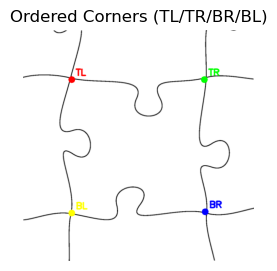

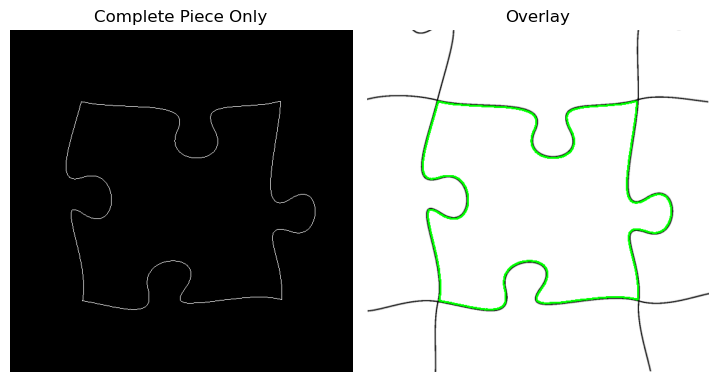

Complete piece contour has 1730 points
Contour area: 91442 pixels
Error processing image 0 (T0_11): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


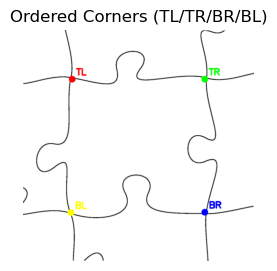

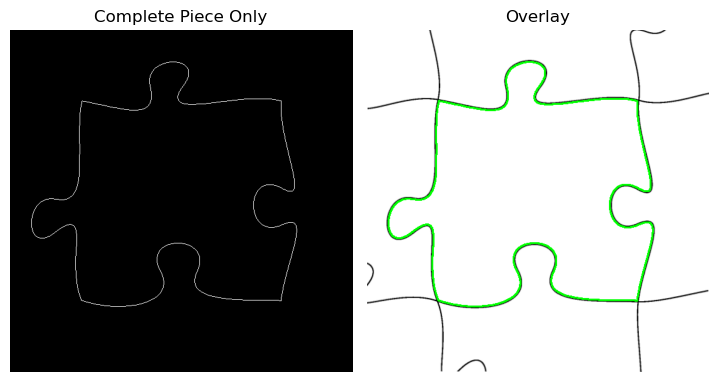

Complete piece contour has 1743 points
Contour area: 104176 pixels
Error processing image 1 (T0_21): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


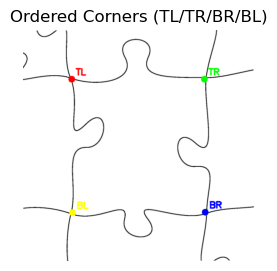

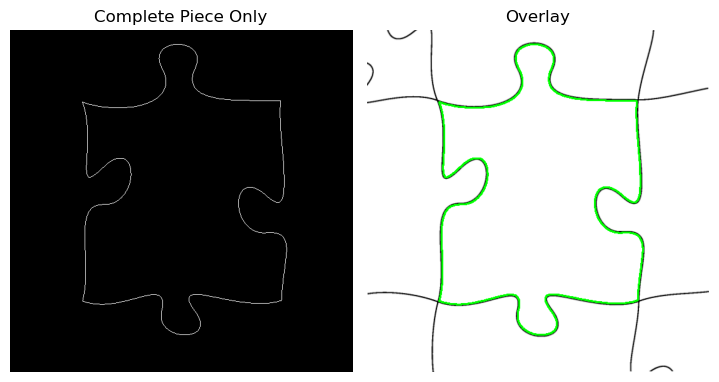

Complete piece contour has 1740 points
Contour area: 98709 pixels
Error processing image 2 (T0_31): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


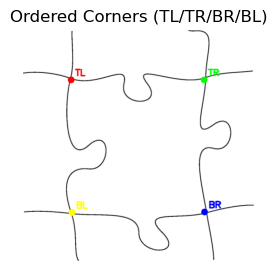

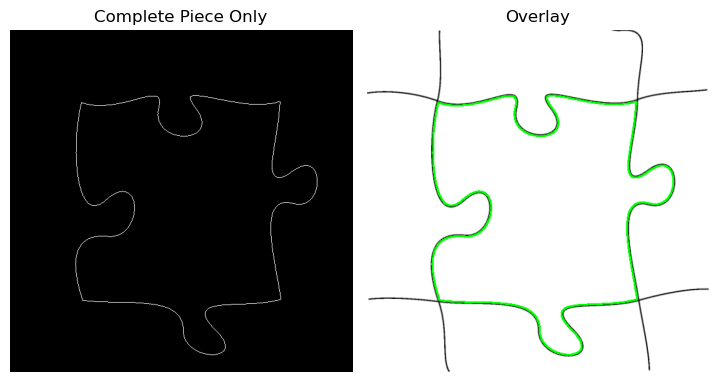

Complete piece contour has 1745 points
Contour area: 100892 pixels
Error processing image 3 (T0_41): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


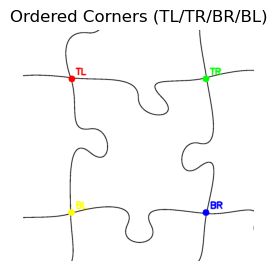

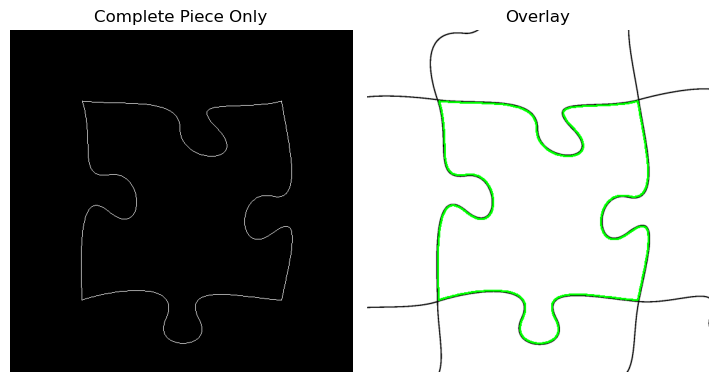

Complete piece contour has 1750 points
Contour area: 88951 pixels
Error processing image 4 (T0_51): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


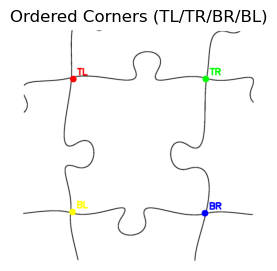

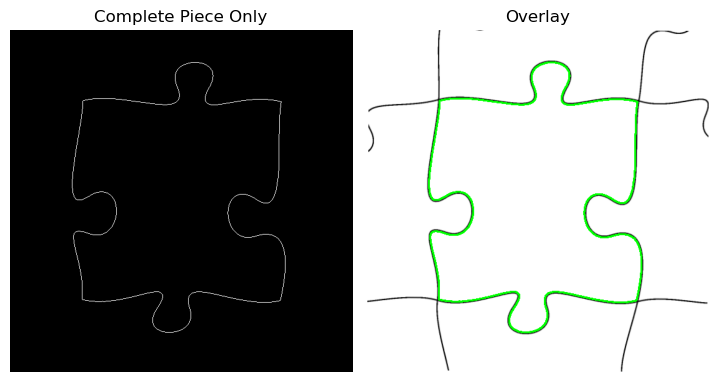

Complete piece contour has 1724 points
Contour area: 99668 pixels
Error processing image 5 (T0_12): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


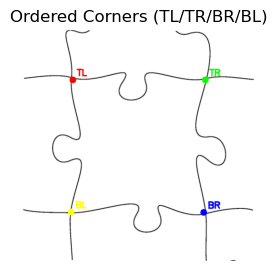

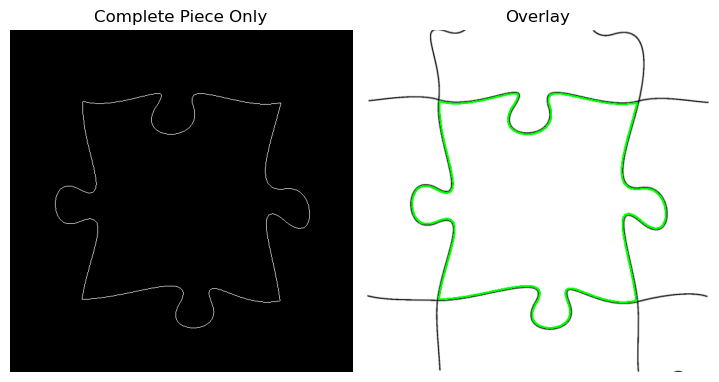

Complete piece contour has 1708 points
Contour area: 95723 pixels
Error processing image 6 (T0_22): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


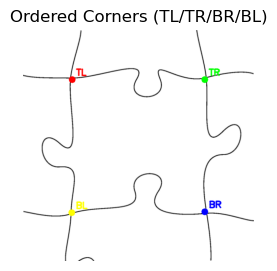

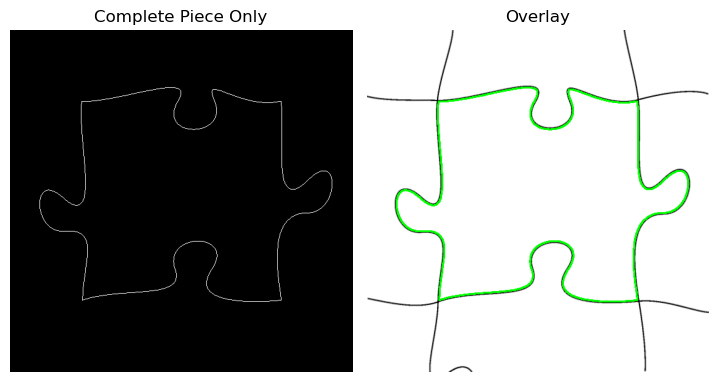

Complete piece contour has 1741 points
Contour area: 99700 pixels
Error processing image 7 (T0_32): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


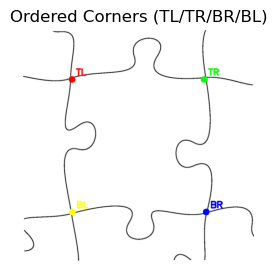

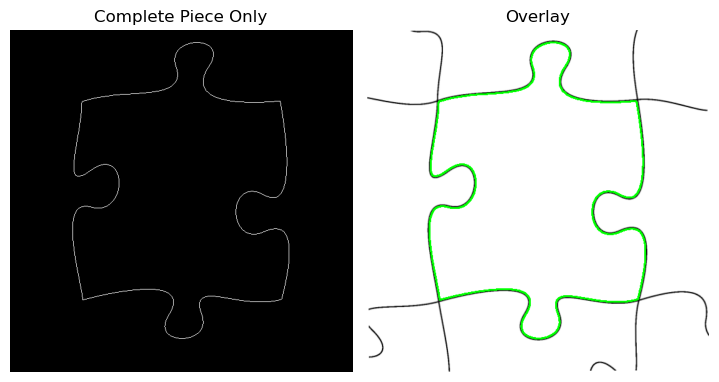

Complete piece contour has 1746 points
Contour area: 105673 pixels
Error processing image 8 (T0_42): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


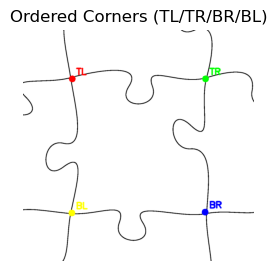

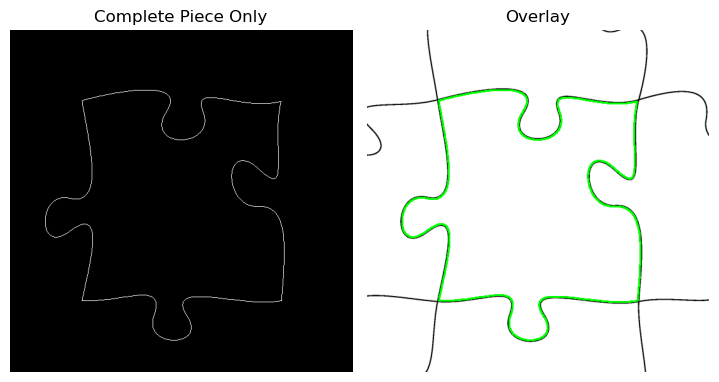

Complete piece contour has 1737 points
Contour area: 96742 pixels
Error processing image 9 (T0_52): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


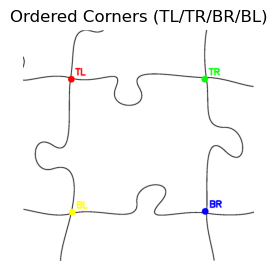

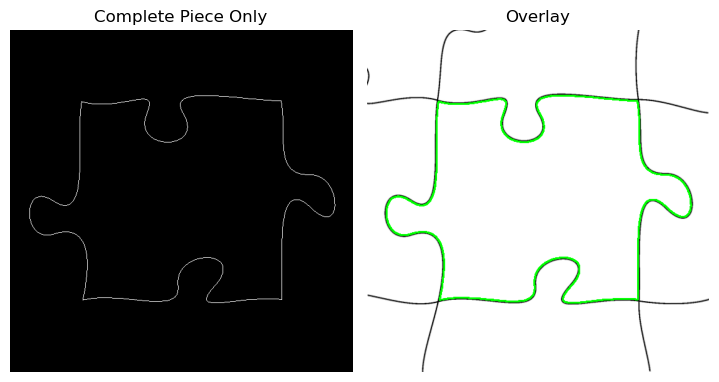

Complete piece contour has 1745 points
Contour area: 103274 pixels
Error processing image 10 (T0_13): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


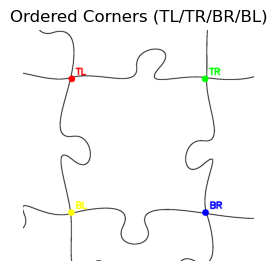

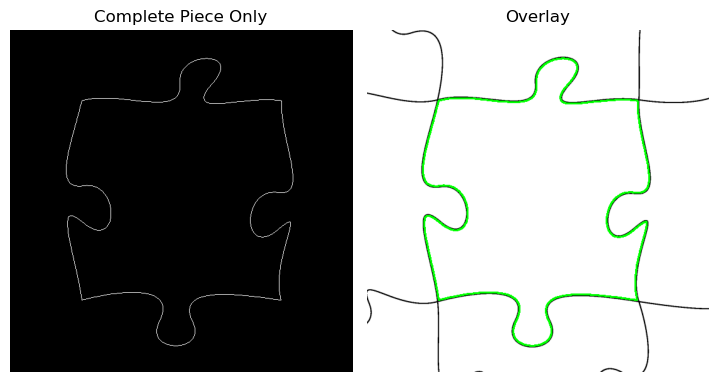

Complete piece contour has 1732 points
Contour area: 105803 pixels
Error processing image 11 (T0_23): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


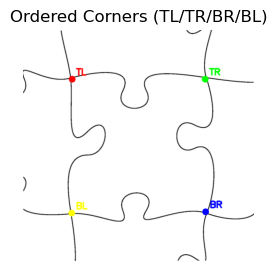

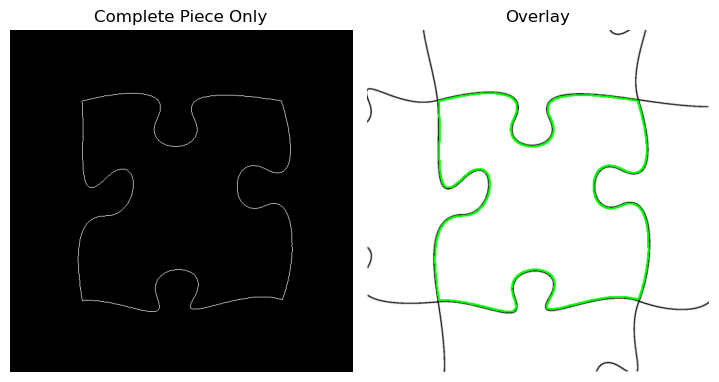

Complete piece contour has 1751 points
Contour area: 91752 pixels
Error processing image 12 (T0_33): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


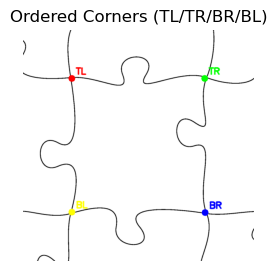

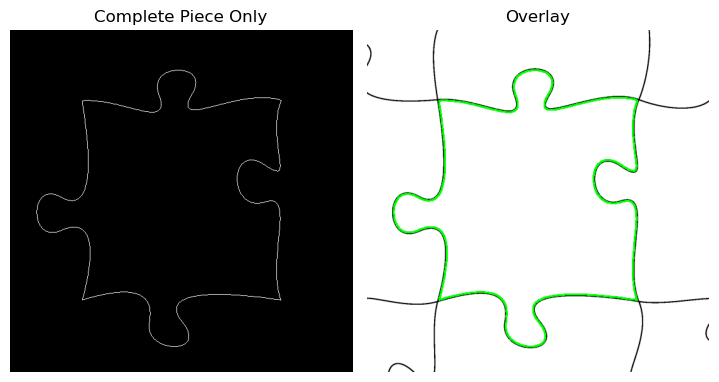

Complete piece contour has 1736 points
Contour area: 99928 pixels
Error processing image 13 (T0_43): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


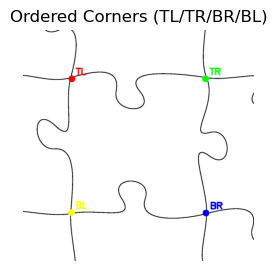

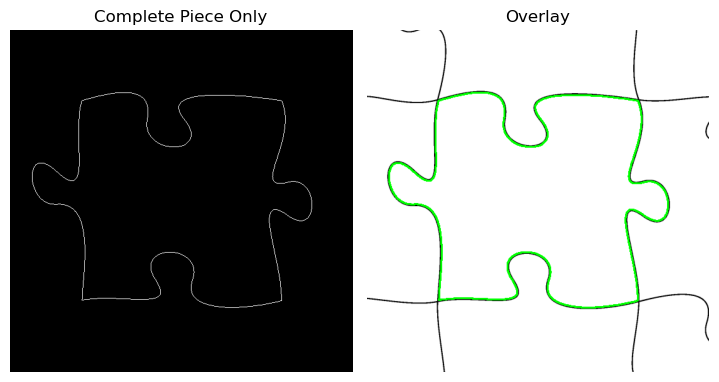

Complete piece contour has 1744 points
Contour area: 100122 pixels
Error processing image 14 (T0_53): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


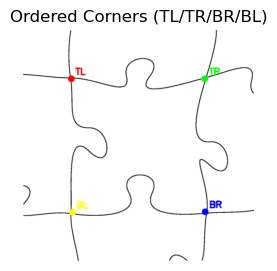

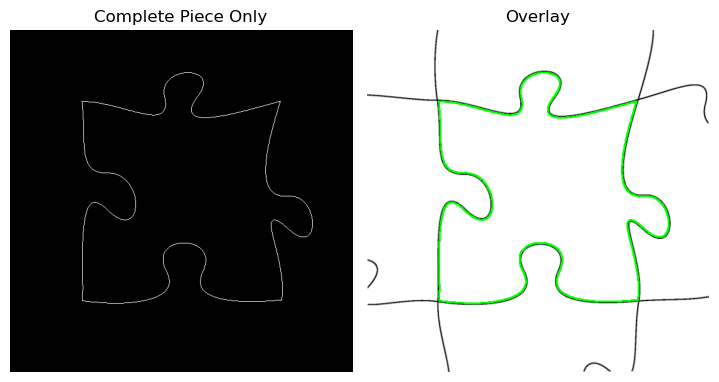

Complete piece contour has 1745 points
Contour area: 87916 pixels
Error processing image 15 (T0_14): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


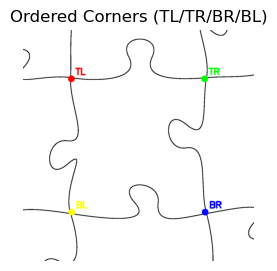

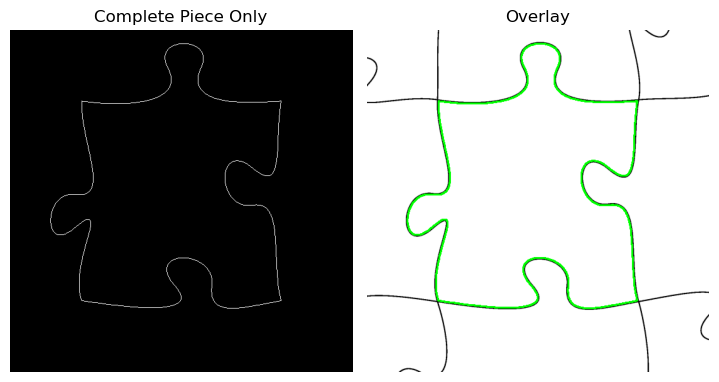

Complete piece contour has 1749 points
Contour area: 97654 pixels
Error processing image 16 (T0_24): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


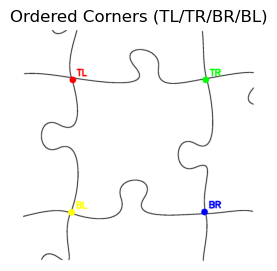

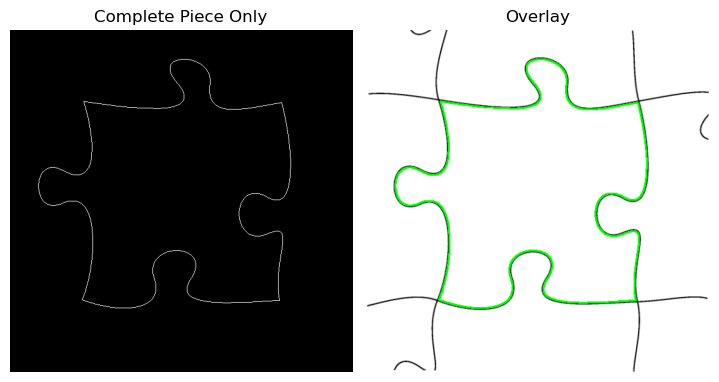

Complete piece contour has 1751 points
Contour area: 97118 pixels
Error processing image 17 (T0_34): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


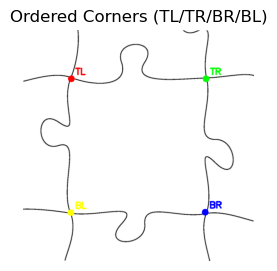

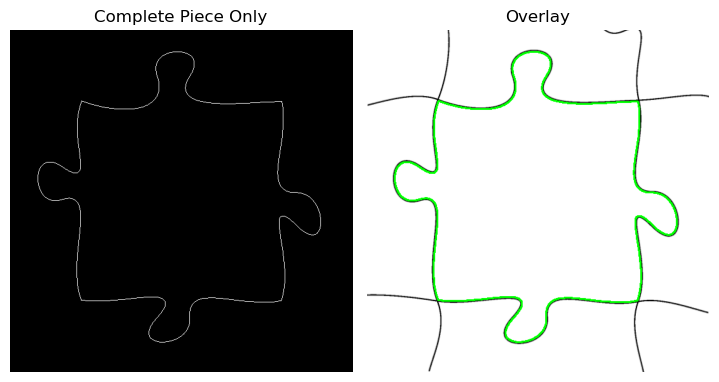

Complete piece contour has 1739 points
Contour area: 114792 pixels
Error processing image 18 (T0_44): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


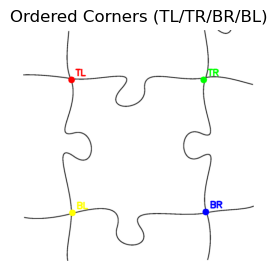

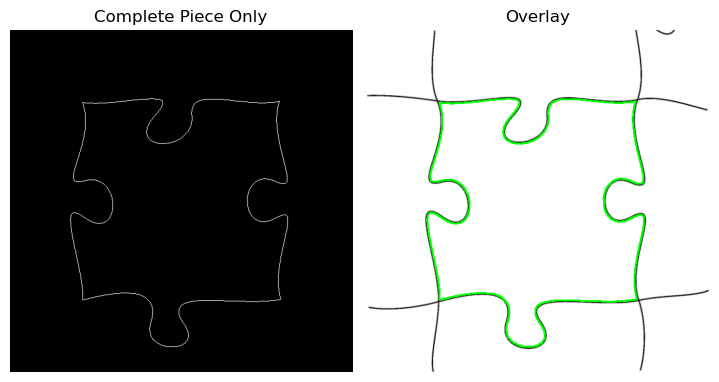

Complete piece contour has 1718 points
Contour area: 96317 pixels
Error processing image 19 (T0_54): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


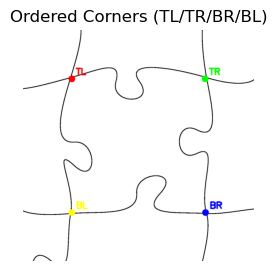

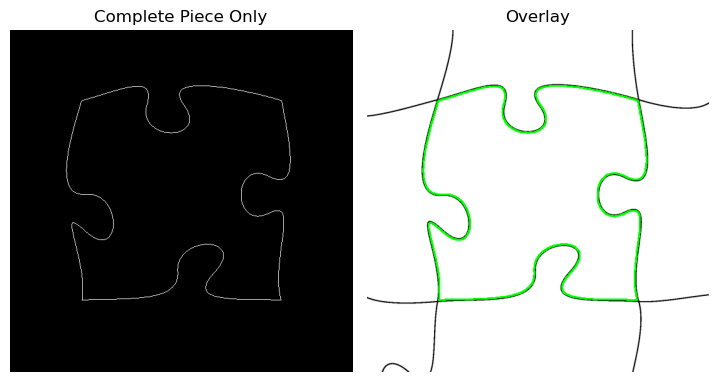

Complete piece contour has 1741 points
Contour area: 93612 pixels
Error processing image 20 (T0_15): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


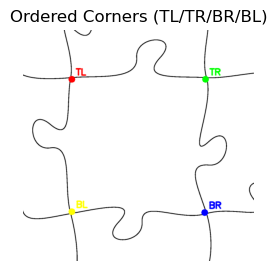

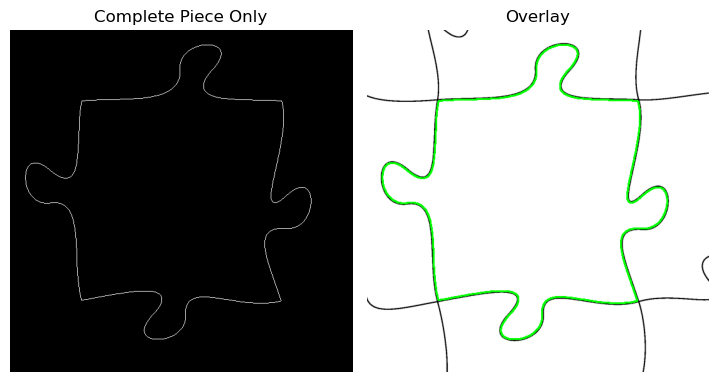

Complete piece contour has 1747 points
Contour area: 114424 pixels
Error processing image 21 (T0_25): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


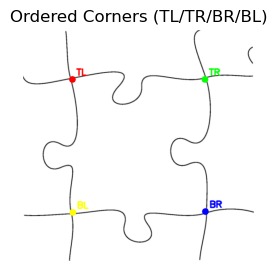

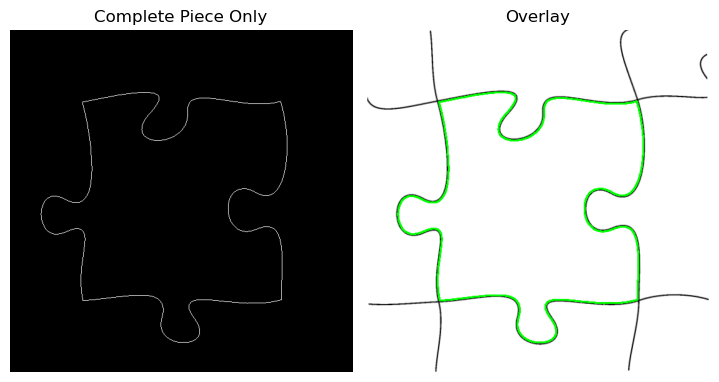

Complete piece contour has 1743 points
Contour area: 99406 pixels
Error processing image 22 (T0_35): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


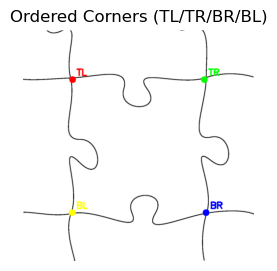

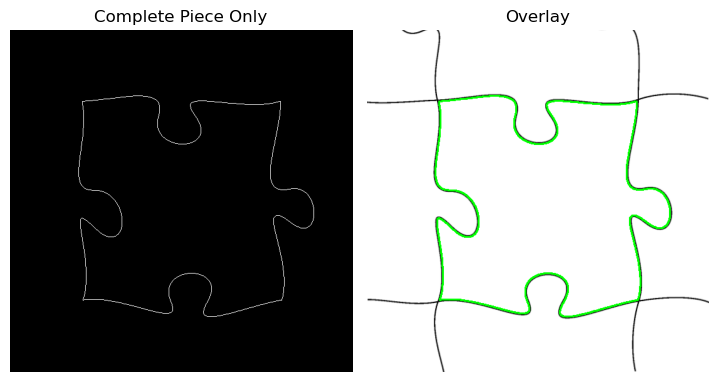

Complete piece contour has 1716 points
Contour area: 94691 pixels
Error processing image 23 (T0_45): classify_puzzle_edges() got an unexpected keyword argument 'visualize'


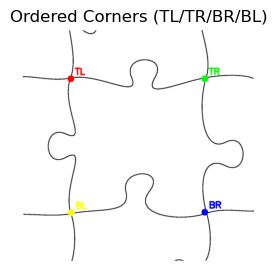

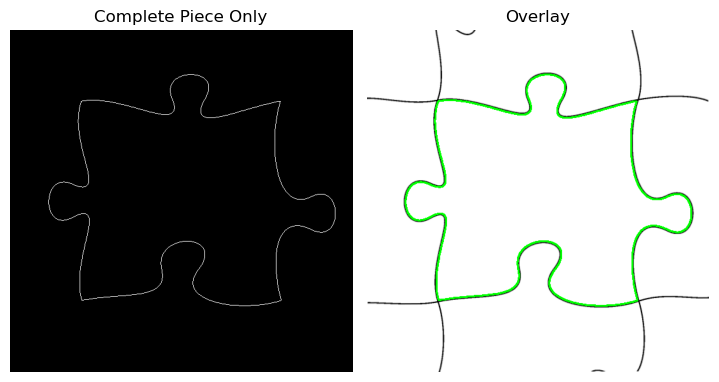

Complete piece contour has 1743 points
Contour area: 99332 pixels
Error processing image 24 (T0_55): classify_puzzle_edges() got an unexpected keyword argument 'visualize'
['T0_11', 'T0_21', 'T0_31', 'T0_41', 'T0_51', 'T0_12', 'T0_22', 'T0_32', 'T0_42', 'T0_52', 'T0_13', 'T0_23', 'T0_33', 'T0_43', 'T0_53', 'T0_14', 'T0_24', 'T0_34', 'T0_44', 'T0_54', 'T0_15', 'T0_25', 'T0_35', 'T0_45', 'T0_55']


In [ ]:
# process all input pieces

def processImages (all_images, image_names):
    allEdges = [] # each row contains 4 entries; one for each edge 
    skipped = []
    allSlots = []
    allTabs = []
    for imageNum in range (len(all_images)):
        try: # if able to read image properly
            edges, classifications = process_each_piece_image (all_images[imageNum])
            #allEdges.append(edges)
            edgeNames = ['top', 'right', 'bottom', 'left']
            for edgeNum in range (4):
                if classifications [edgeNum] == 'slot':
                    allSlots.append ([edges[edgeNum],image_names[imageNum],edgeNames[edgeNum]])
                elif classifications [edgeNum] == 'tab':
                    allTabs.append ([edges[edgeNum],image_names[imageNum],edgeNames[edgeNum]])

        except Exception as e: # if there is an error processing a piece
            #allEdges.append([]) # add a blank item in its place
            skipped.append(image_names[imageNum]) # list of all skipped pieces
            
            print(f"Error processing image {imageNum} ({image_names[imageNum]}): {e}")

            continue  # Skip to next iteration
    return (allSlots,allTabs, skipped)

allSlots, allTabs , skipped = processImages(all_images, image_names)
print (skipped)


In [28]:
# save training examples
import pickle


# # UNCOMMENT FOR TRAINING
# with open('allSlotsTrain.pkl', 'wb') as f:
#     pickle.dump(allSlots, f)

# with open('allTabsTrain.pkl', 'wb') as f:
#     pickle.dump(allTabs, f)
    
# with open('skippedPiecesTrain.pkl', 'wb') as f:
#     pickle.dump(skipped, f)
# print (skipped)

# UNCOMMENT FOR TESTING
with open('allSlotsTest.pkl', 'wb') as f:
    pickle.dump(allSlots, f)

with open('allTabsTest.pkl', 'wb') as f:
    pickle.dump(allTabs, f)
    
with open('skippedPiecesTest.pkl', 'wb') as f:
    pickle.dump(skipped, f)
print (skipped)

['T0_11', 'T0_21', 'T0_31', 'T0_41', 'T0_51', 'T0_12', 'T0_22', 'T0_32', 'T0_42', 'T0_52', 'T0_13', 'T0_23', 'T0_33', 'T0_43', 'T0_53', 'T0_14', 'T0_24', 'T0_34', 'T0_44', 'T0_54', 'T0_15', 'T0_25', 'T0_35', 'T0_45', 'T0_55']
